In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib as mpl
import matplotlib.cm as cm


In [75]:
assessor_dir = 'datasets/assessorSequential.csv'
df = pd.read_csv(assessor_dir)

In [76]:
df = df.drop(columns=['Unnamed: 0','X11th.Draw','PIN','Township Code','Neighborhood Code','Age','Longitude','Latitude','ZIP'])

In [77]:
draw_col = df.columns[2:12]
draw_col

Index(['X1st.Draw', 'X2nd.Draw', 'X3rd.Draw', 'X4th.Draw', 'X5th.Draw',
       'X6th.Draw', 'X7th.Draw', 'X8th.Draw', 'X9th.Draw', 'X10th.Draw'],
      dtype='object')

In [78]:
df['avg_draw'] = df[draw_col].mean(axis=1)
df = df.drop(columns=draw_col)

In [79]:
df_full = df.copy()
df_reduced = df.copy()

In [80]:
df_full[~df_full.isin(['NaN', 'NaT']).any(axis=1)]
df_full.shape
df_full.dropna(inplace=True)
df_full.shape

(149, 5)

In [81]:
#assign 0 to <15 and 1 to >=15
df_full['avg_lead_target'] = np.where(df_full['avg_draw']<15, 0, 1)

In [82]:
from imblearn.over_sampling import SMOTE

In [83]:
df_full['sale_price'] = df_full['Sale Price']
df_full = df_full.drop(columns=['Sale Price'])

df_full['tract_income'] = df_full['Tract Median Income']
df_full = df_full.drop(columns=['Tract Median Income'])

In [84]:
df_full1 = df_full[['sale_price','tract_income','avg_lead_target']]

In [85]:
X = df_full1[['sale_price','tract_income']]
y = df_full1['avg_lead_target']

In [86]:
df_full1

,sale_price,tract_income,avg_lead_target
0,280000.0,122727.0,0
17,219000.0,98281.0,0
20,147400.0,30069.0,1
21,330000.0,110344.0,0
36,280000.0,100361.0,0
...,...,...,...
1749,205000.0,60755.0,0
1753,399900.0,73300.0,1
1760,590000.0,122727.0,0
1784,145900.0,46517.0,0


In [87]:
# Perform SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df.columns = df_full1.columns

# Shuffle the resampled data
resampled_df = resampled_df.sample(frac=1, random_state=42)

In [88]:
resampled_df['avg_lead_target'].value_counts()

1    121
0    121
Name: avg_lead_target, dtype: int64

In [89]:
resampled_df

,sale_price,tract_income,avg_lead_target
24,1.480000e+06,142583.000000,1
6,4.640000e+05,110344.000000,0
152,3.718882e+05,60272.171780,1
209,8.315072e+04,36474.352925,1
237,1.957185e+06,103756.401471,1
...,...,...,...
106,5.200000e+04,22905.000000,0
14,2.200000e+05,44738.000000,0
92,4.400000e+05,75759.000000,0
179,9.252391e+04,46431.952907,1


In [90]:
from sklearn.model_selection import train_test_split

X = resampled_df[['sale_price','tract_income']]
y = resampled_df['avg_lead_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
log_reg = sm.Logit(y_train,X_train).fit()

Optimization terminated successfully.
         Current function value: 0.660982
         Iterations 4


In [92]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:        avg_lead_target   No. Observations:                  162
Model:                          Logit   Df Residuals:                      160
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                 0.04640
Time:                        18:03:27   Log-Likelihood:                -107.08
converged:                       True   LL-Null:                       -112.29
Covariance Type:            nonrobust   LLR p-value:                  0.001246
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
sale_price    2.709e-06   9.55e-07      2.837      0.005    8.37e-07    4.58e-06
tract_income -1.535e-05   5.86e-06     -2.618      0.009   -2.68e-05   -3.86e-06


In [93]:
yhat = log_reg.predict(X_test)
prediction = list(map(round, yhat))
  
# comparing original and predicted values of y
print('Actual values', list(y_test.values))
print('Predictions :', prediction)

Actual values [1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]
Predictions : [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0]


In [94]:
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
  
# confusion matrix
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction)*100)

Confusion Matrix : 
 [[19 21]
 [23 17]]
Test accuracy =  45.0


In [95]:
import seaborn as sns

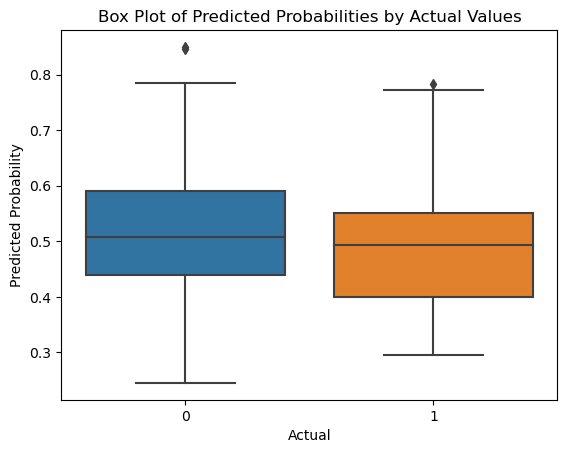

In [100]:
results = pd.DataFrame({'actual': y_test, 'predicted': yhat})
# Create box plot using seaborn
sns.boxplot(x='actual', y='predicted', data=results)
plt.xlabel("Actual")
plt.ylabel("Predicted Probability")
plt.title("Box Plot of Predicted Probabilities by Actual Values")
plt.show()

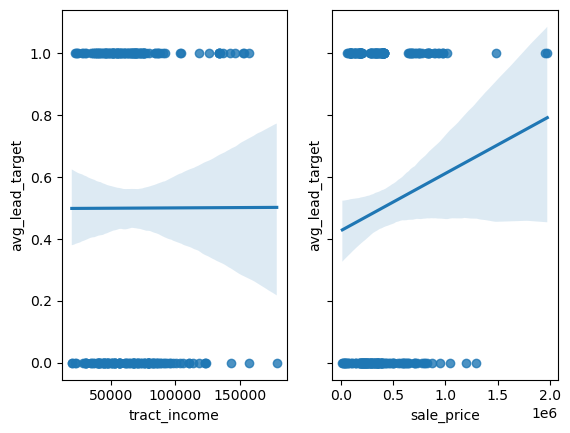

In [97]:
# partial regression plots
fig, axs = plt.subplots(1, 2, sharey=True)
sns.regplot(x='tract_income', y='avg_lead_target', data=resampled_df, ax=axs[0])
sns.regplot(x='sale_price', y='avg_lead_target', data=resampled_df, ax=axs[1])
plt.show()

In [98]:
log_reg_reduced = smf.logit(formula='avg_lead_target ~ sale_price', data=df_full1).fit()

Optimization terminated successfully.
         Current function value: 0.472080
         Iterations 6


In [99]:
log_reg_reduced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        avg_lead_target   No. Observations:                  149
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Apr 2023   Pseudo R-squ.:                 0.02300
Time:                        18:03:28   Log-Likelihood:                -70.340
converged:                       True   LL-Null:                       -71.996
Covariance Type:            nonrobust   LLR p-value:                   0.06880
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9554      0.354     -5.527      0.000      -2.649      -1.262
sale_price  1.193e-06   6.47e-07      1.845      0.065   -7.44e-08    2.46e-06
==============================================================================
"""